<a href="https://colab.research.google.com/github/akshat2635/auto-eval/blob/main/auto_eval_TATR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q easyocr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 48.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import os
import csv
import easyocr
from tqdm.auto import tqdm

from PIL import Image
from PIL import ImageDraw
import cv2

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Patch

from torchvision import transforms
from transformers import AutoModelForObjectDetection
from transformers import TableTransformerForObjectDetection

In [3]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
# model.to(device)
print(device)

cuda


In [4]:
def preprocess_image(pil_img):
    # Convert PIL image to NumPy array (OpenCV format)
    img = np.array(pil_img)

    # Convert RGB image to grayscale
    # gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Apply thresholding to binarize the image
    _, binary_img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)

    # Apply morphological operations to enhance the text
    kernel = np.ones((3, 3), np.uint8)
    morphed_img = cv2.morphologyEx(binary_img, cv2.MORPH_CLOSE, kernel)

    # Convert the processed image back to PIL format
    processed_pil_img = Image.fromarray(morphed_img)

    return processed_pil_img

In [5]:
class MaxResize(object):
    def __init__(self, max_size=800):
        self.max_size = max_size

    def __call__(self, image):
        width, height = image.size
        current_max_size = max(width, height)
        scale = self.max_size / current_max_size
        resized_image = image.resize((int(round(scale*width)), int(round(scale*height))))

        return resized_image

detection_transform = transforms.Compose([
    MaxResize(800),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [6]:
dir="/content/drive/MyDrive/anand_mishra/Train_Samples_V0"
paths=[]
# imgs=[]
for root,dirs,files in os.walk(dir):
    for file in files:
        path=dir+"/"+file
        paths.append(path)
# crash ho rha tha bar bar isliye kam photos li
paths=paths[:6]

In [7]:
model = AutoModelForObjectDetection.from_pretrained("microsoft/table-transformer-detection", revision="no_timm")
model.to(device)
model.config.id2label

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/76.5k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

{0: 'table', 1: 'table rotated'}

In [8]:
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h), (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)


def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b


# update id2label to include "no object"
id2label = model.config.id2label
id2label[len(model.config.id2label)] = "no object"


def outputs_to_objects(outputs, img_size, id2label):
    m = outputs.logits.softmax(-1).max(-1)
    pred_labels = list(m.indices.detach().cpu().numpy())[0]
    pred_scores = list(m.values.detach().cpu().numpy())[0]
    pred_bboxes = outputs['pred_boxes'].detach().cpu()[0]
    pred_bboxes = [elem.tolist() for elem in rescale_bboxes(pred_bboxes, img_size)]

    objects = []
    for label, score, bbox in zip(pred_labels, pred_scores, pred_bboxes):
        class_label = id2label[int(label)]
        if not class_label == 'no object':
            objects.append({'label': class_label, 'score': float(score),
                            'bbox': [float(elem) for elem in bbox]})

    return objects

In [9]:
# objects = outputs_to_objects(outputs, image.size, id2label)
# # objects['bbox'][3]+=200
# print(objects)

In [10]:
def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    import io
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img


def visualize_detected_tables(img, det_tables, out_path=None):
    plt.imshow(img, interpolation="lanczos")
    fig = plt.gcf()
    fig.set_size_inches(20, 20)
    ax = plt.gca()

    for det_table in det_tables:
        bbox = det_table['bbox']

        if det_table['label'] == 'table':
            facecolor = (1, 0, 0.45)
            edgecolor = (1, 0, 0.45)
            alpha = 0.3
            linewidth = 2
            hatch='//////'
        elif det_table['label'] == 'table rotated':
            facecolor = (0.95, 0.6, 0.1)
            edgecolor = (0.95, 0.6, 0.1)
            alpha = 0.3
            linewidth = 2
            hatch='//////'
        else:
            continue

        rect = patches.Rectangle(bbox[:2], bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=linewidth,
                                    edgecolor='none',facecolor=facecolor, alpha=0.1)
        ax.add_patch(rect)
        rect = patches.Rectangle(bbox[:2], bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=linewidth,
                                    edgecolor=edgecolor,facecolor='none',linestyle='-', alpha=alpha)
        ax.add_patch(rect)
        rect = patches.Rectangle(bbox[:2], bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=0,
                                    edgecolor=edgecolor,facecolor='none',linestyle='-', hatch=hatch, alpha=0.2)
        ax.add_patch(rect)

    plt.xticks([], [])
    plt.yticks([], [])

    legend_elements = [Patch(facecolor=(1, 0, 0.45), edgecolor=(1, 0, 0.45),
                                label='Table', hatch='//////', alpha=0.3),
                        Patch(facecolor=(0.95, 0.6, 0.1), edgecolor=(0.95, 0.6, 0.1),
                                label='Table (rotated)', hatch='//////', alpha=0.3)]
    plt.legend(handles=legend_elements, bbox_to_anchor=(0.5, -0.02), loc='upper center', borderaxespad=0,
                    fontsize=10, ncol=2)
    plt.gcf().set_size_inches(10, 10)
    plt.axis('off')

    if out_path is not None:
      plt.savefig(out_path, bbox_inches='tight', dpi=150)

    return fig

In [11]:
def objects_to_crops(img, tokens, objects, class_thresholds, padding=10):
    """
    Process the bounding boxes produced by the table detection model into
    cropped table images and cropped tokens.
    """

    table_crops = []
    for obj in objects:
        if obj['score'] < class_thresholds[obj['label']]:
            continue

        cropped_table = {}

        bbox = obj['bbox']
        bbox = [bbox[0]-padding, bbox[1]-padding, bbox[2]+padding, bbox[3]+padding]

        cropped_img = img.crop(bbox)

        table_tokens = [token for token in tokens if iob(token['bbox'], bbox) >= 0.5]
        for token in table_tokens:
            token['bbox'] = [token['bbox'][0]-bbox[0],
                             token['bbox'][1]-bbox[1],
                             token['bbox'][2]-bbox[0],
                             token['bbox'][3]-bbox[1]]

        # If table is predicted to be rotated, rotate cropped image and tokens/words:
        if obj['label'] == 'table rotated':
            cropped_img = cropped_img.rotate(270, expand=True)
            for token in table_tokens:
                bbox = token['bbox']
                bbox = [cropped_img.size[0]-bbox[3]-1,
                        bbox[0],
                        cropped_img.size[0]-bbox[1]-1,
                        bbox[2]]
                token['bbox'] = bbox

        cropped_table['image'] = cropped_img
        cropped_table['tokens'] = table_tokens

        table_crops.append(cropped_table)

    return table_crops

In [12]:
images=[]
tables=[]
cropped_tables=[]
for path in paths:
    image = Image.open(path).convert("RGB")
    image=preprocess_image(image)

    pixel_values = detection_transform(image).unsqueeze(0)
    pixel_values = pixel_values.to(device)
    print(pixel_values.shape)
    with torch.no_grad():
        outputs = model(pixel_values)

    objects = outputs_to_objects(outputs, image.size, id2label)
    fig = visualize_detected_tables(image, objects)
    # tables.append(fig2img(fig))

    tokens = []
    detection_class_thresholds = {
        "table": 0.5,
        "table rotated": 0.5,
        "no object": 10
    }
    crop_padding = 10
    tables_crops = objects_to_crops(image, tokens, objects, detection_class_thresholds, padding=20)
    cropped_table = tables_crops[0]['image'].convert("RGB")
    cropped_tables.append(cropped_table)

    images.append(image)

torch.Size([1, 3, 800, 685])
torch.Size([1, 3, 800, 688])
torch.Size([1, 3, 800, 682])
torch.Size([1, 3, 800, 698])
torch.Size([1, 3, 800, 695])
torch.Size([1, 3, 800, 679])
Error in callback <function flush_figures at 0x79cfc2137a30> (for post_execute):


KeyboardInterrupt: 

In [13]:
for i in tables:
    i.show()

In [14]:
for i in cropped_tables:
    i.show()

In [15]:
# tebles=[]
# for image in images:
#     objects = outputs_to_objects(outputs, image.size, id2label)
#     fig = visualize_detected_tables(image, objects)
#     tables.append(fig2img(fig))

In [16]:
# tokens = []
# detection_class_thresholds = {
#     "table": 0.5,
#     "table rotated": 0.5,
#     "no object": 10
# }
# crop_padding = 10
# cropped_tables=[]
# for image in images:
#     tables_crops = objects_to_crops(image, tokens, objects, detection_class_thresholds, padding=20)
#     cropped_table = tables_crops[0]['image'].convert("RGB")
#     cropped_tables.append(cropped_table)

In [17]:
def plot_results(cells, class_to_visualize):
    if class_to_visualize not in structure_model.config.id2label.values():
      raise ValueError("Class should be one of the available classes")

    plt.figure(figsize=(16,10))
    plt.imshow(cropped_table)
    ax = plt.gca()

    for cell in cells:
        score = cell["score"]
        bbox = cell["bbox"]
        label = cell["label"]

        if label == class_to_visualize:
          xmin, ymin, xmax, ymax = tuple(bbox)

          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color="red", linewidth=3))
          text = f'{cell["label"]}: {score:0.2f}'
          ax.text(xmin, ymin, text, fontsize=15,
                  bbox=dict(facecolor='yellow', alpha=0.5))
          plt.axis('off')

In [18]:
def get_cell_coordinates_by_row(table_data):
    # Extract rows and columns
    rows = [entry for entry in table_data if entry['label'] == 'table row']
    columns = [entry for entry in table_data if entry['label'] == 'table column']

    # Sort rows and columns by their Y and X coordinates, respectively
    rows.sort(key=lambda x: x['bbox'][1])
    columns.sort(key=lambda x: x['bbox'][0])

    # Function to find cell coordinates
    def find_cell_coordinates(row, column):
        cell_bbox = [column['bbox'][0], row['bbox'][1], column['bbox'][2], row['bbox'][3]]
        return cell_bbox

    # Generate cell coordinates and count cells in each row
    cell_coordinates = []

    for row in rows:
        row_cells = []
        for column in columns:
            cell_bbox = find_cell_coordinates(row, column)
            row_cells.append({'column': column['bbox'], 'cell': cell_bbox})

        # Sort cells in the row by X coordinate
        row_cells.sort(key=lambda x: x['column'][0])

        # Append row information to cell_coordinates
        cell_coordinates.append({'row': row['bbox'], 'cells': row_cells, 'cell_count': len(row_cells)})

    # Sort rows from top to bottom
    cell_coordinates.sort(key=lambda x: x['row'][1])

    return cell_coordinates



In [19]:
structure_model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-structure-recognition-v1.1-all")
structure_model.to(device)

config.json:   0%|          | 0.00/76.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

TableTransformerForObjectDetection(
  (model): TableTransformerModel(
    (backbone): TableTransformerConvModel(
      (conv_encoder): TableTransformerConvEncoder(
        (model): ResNetBackbone(
          (embedder): ResNetEmbeddings(
            (embedder): ResNetConvLayer(
              (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
              (normalization): TableTransformerFrozenBatchNorm2d()
              (activation): ReLU()
            )
            (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          )
          (encoder): ResNetEncoder(
            (stages): ModuleList(
              (0): ResNetStage(
                (layers): Sequential(
                  (0): ResNetBasicLayer(
                    (shortcut): Identity()
                    (layer): Sequential(
                      (0): ResNetConvLayer(
                        (convolution): Conv2d(64, 64, kernel_size=(3, 3), stride=(

In [20]:
structure_transform = transforms.Compose([
    MaxResize(1000),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# pixel_values = structure_transform(cropped_table).unsqueeze(0)
# pixel_values = pixel_values.to(device)
# print(pixel_values.shape)

# with torch.no_grad():
#   outputs = structure_model(pixel_values)

In [21]:
reader = easyocr.Reader(['en']) # this needs to run only once to load the model into memory

def apply_ocr(cell_coordinates):
    # let's OCR row by row
    data = dict()
    max_num_columns = 0
    for idx, row in enumerate(tqdm(cell_coordinates)):
      row_text = []
      for cell in row["cells"]:
        # crop cell out of image
        cell_image = np.array(cropped_table.crop(cell["cell"]))
        # apply OCR
        result = reader.readtext(np.array(cell_image))
        if len(result) > 0:
          # print([x[1] for x in list(result)])
          text = " ".join([x[1] for x in result])
          row_text.append(text)

      if len(row_text) > max_num_columns:
          max_num_columns = len(row_text)

      data[idx] = row_text

    print("Max number of columns:", max_num_columns)

    # pad rows which don't have max_num_columns elements
    # to make sure all rows have the same number of columns
    for row, row_data in data.copy().items():
        if len(row_data) != max_num_columns:
          row_data = row_data + ["" for _ in range(max_num_columns - len(row_data))]
        data[row] = row_data

    return data

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

torch.Size([1, 3, 968, 1000])
1) rows : 11  cols : 3


  0%|          | 0/11 [00:00<?, ?it/s]

Max number of columns: 3
['SN', 'Statement', 'TRUE/FALSE']
['1', "If Rd thon 81 |r '( (f thc mlrix (t ix |c) L,hc MucliclcI) (list,anc; a € betwecn thc origin anc 4hc (1. ((Mf] [xcvimg,", 'IRUE']
['2', 'PCA becomos cquivalcnt 1o LIDA il wc projcct cl oucsh class using FCA independently Selnp)lcx', 'TRvE']
['3', 'For a particular €, thc valuc ol thc prolhility mass function can Iy: grcatcr than one.', 'Trve']
['4', 'The PCA will project 2D-data points to [1,0]"\' if variance(c) variancely).', 'TRuE']
['5', 'If data distributions exactly follow y-x, thcn thc rank of the covariance matrix will be zero.', 'True']
['6', 'If X and Y are two rcal-valued random variables such that Cov(X, Y) < 0 then at least one of X or Y must havc negative variance i.e. either o(X) < 0 or o(Y) < 0.', 'Fake']
['7', 'Naive Bayes assumes that all features are conditionally independent given the class label.', 'TRUE']
['8', 'LDA is sensitive to outliers in the dataset.', 'TRve']
['9', 'A die is loaded so that the

  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Max number of columns: 3
['YMU / O `', 'TRUE/FALSE', '']
['SN', "Statement 1 .Sfi' 0 the Euclidean distance", 'Trn)e']
['1', 'of Aho matrix (" is oqual u UIIO If a € thon {1 (1( %(\' between the origin and the (L. inc PCA Rd , poing,', 'V']
['2', 'UI UWVrI PCA becomes equivalent to LDA if we project sa.pies independently. or than', 'T 7"']
['3', 'For & particular %, the value Of thle pLObdUffey ICno LUIIUU _ one.', 'T 0uC']
['5', '1 IC 1 Uf W II piujelu AJ UCum PUIIIUD L~ KL umy [ijvcbahehiytygvs If data distributions exactly follow y-x; then the rank of the covariance matrix', 'FALSE']
['6', 'If X and Y are two real-valued random variables such that Cov(X,Y) < 0 then at least one of X or Y must have negative variance i.e either o(X) < 0 O1 o(Y) < 0.', 'FALSE']
['7', 'Naive Bayes assumes that all features are conditionally independent given the class label:', 'TRUE']
['8', 'LDA is sensitive to outliers in the dataset.', 'AFALSE']
['9', 'A die is loaded s0 that the probability of a face

  0%|          | 0/11 [00:00<?, ?it/s]

Max number of columns: 3
['SN', 'Statement', 'TRUE /FALSE']
['1', "If a € (hn #1 (rhc  (f (le matrix (d' is tc fhc Fclick'An clistanc bct wecn tho origin anal Aho p)im (. Ra , o[ua]", 'a Isc']
['2', "PCA hecomcs (qquivalc tc) HIJA if wc ro)jec cf each class using FG'A independcntly. Samplcss", 'Tvu &']
['3', 'For a particular T, thc valuc cf thc prolyhility Irass function can hc greatet than one.', 'Tra']
['4', 'The PCA will projcct 2D-data points to [1, (]T if variance(I) variancely):', 'Ya (ce']
['5', 'If data distributions exactly follow y-x; then the rank of the covariance matrix will be zero.', 'Tza<']
['6', 'If X and Y are two real-valued random variables such that Cov(X Y) < 0 then at least one of X or Y must have negative variance i.e either o(X) < 0 Or o(Y) < 0.', 'Tra €']
['7', 'Naive Bayes assumes that all features are conditionally independent given the class label', 'Tru ']
['8', 'LDA is sensitive to outliers in the dataset.', 'fzac']
['9', 'A die is loaded s0 that the pro

  0%|          | 0/11 [00:00<?, ?it/s]

Max number of columns: 3
['SN', 'Statement', 'O']
['1', 'Ifa e md , thon 8 trace of thc matrix aa" ix 6o) (hc Kliclcsn (list,anic;: )t wrrn tho origin and tho (L. ((Ha] point', '']
['2', 'PCA becomcs cquivalcnt to LDA if wc projcc:t, off c:h class using, PCA ndependently: sapl%s', '']
['3', 'For a particular the value of the probability Inass fnctic GAn Ix: greatsr than )ne. I ,', '']
['4', 'The PCA will project 2D-data points to [1,0jT if variance(T) voriotcs:(y):', '']
['5', 'If data distributions exactly follow y-X; then the rank of thc covariance matrix will be zero.', '']
['6', '[f X and Y are two real-valued random variables such that Cov(X,Y) < 0 then at least one of X or Y must have negative variance i.e. either o(X ) < 0 Or T(Y) < 0.', '']
['7', 'Naive Bayes assumes that all features are conditionally independent given the class label:', '']
['8', 'LDA is sensitive to outliers in the dataset.', '']
['9', 'A die is loaded s0 that the probability of a face comning Up is proporti

  0%|          | 0/6 [00:00<?, ?it/s]

Max number of columns: 3
['will hc zero.', '', '']
['If X and Y are two real-valued random variables such that Cov(X,Y) < () then at, least one of X or Y must have negative variance i.e. cithcr G(X ) < 0 or G(Y) < 0.', '', '']
['77', 'Naive Bayes assumes that all features are conditionally independent given the class label.', 'Txu']
['LDA is sensitive to outliers in the dataset.', '', '']
["A die is loaded so that the probability of a face coming Up is proportiuual to the' number on that face. The die is rolled with outcomc X The experterl value o X i8 greater than 4.", '', '']
['10', 'B = {l1,11 (-1,0T} is one of the basis in 2D-space.', 'Tm']
torch.Size([1, 3, 972, 1000])
6) rows : 11  cols : 3


  0%|          | 0/11 [00:00<?, ?it/s]

Max number of columns: 3
['SN', 'Statement', 'TRUE /FALSE']
['1', 'I ( e Rd, thcn 8 tracc of the matrix aat is to thc Euclidcan distance hctwccn Ahc origin andl thc 0 . equal point', 'Ysus']
['2', 'PCA lycomcs cquivalcnt to LDA if we project samples of each class using PCA indlcpendlently:', 'Vauul']
['3', 'For a particular T, thc value of the probability mass function can be greater than one.', 'Yallol']
['4', 'Thc PCA will project 2D-data points to [1, 0JT if variance(c) variancely):', 'Yauyl']
['5', 'If data distributions exactly follow y-x; then the rank of the covariance matrix will bc zero.', 'Yalal']
['6', 'If X and Y are two real-valued random variables such that Cou(X, Y) < 0 then at least one of X or Y must have negative variance i.e. either o(X) 0 or o(Y) < 0.', 'Hul']
['Naive Bayes assumes that all features are conditionally independent given the class label:', 'Yuue', '']
['8', 'LDA is sensitive to outliers in the dataset.', 'Yul']
['9', 'A die is loaded so that the probab

,0,1,2,3,4,5,6,7,8,9,10
0,TRUE/FALSE,IRUE,TRvE,Trve,TRuE,True,Fake,TRUE,TRve,Fale,
1,,Trn)e,V,"T 7""",T 0uC,FALSE,FALSE,TRUE,AFALSE,TREE,True
2,TRUE /FALSE,a Isc,Tvu &,Tra,Ya (ce,Tza<,Tra €,Tru,fzac,False,FGue
3,O,,,,,,,,,,7i
4,,,Txu,,,Tm,None,None,None,None,None
5,TRUE /FALSE,Ysus,Vauul,Yallol,Yauyl,Yalal,Hul,,Yul,Ysuck,Yall


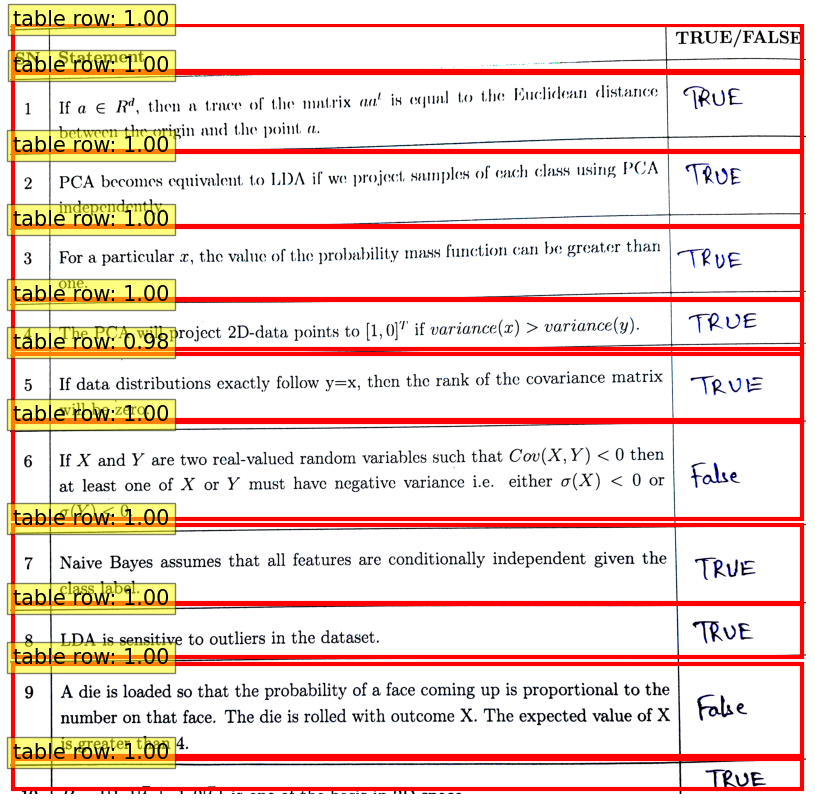

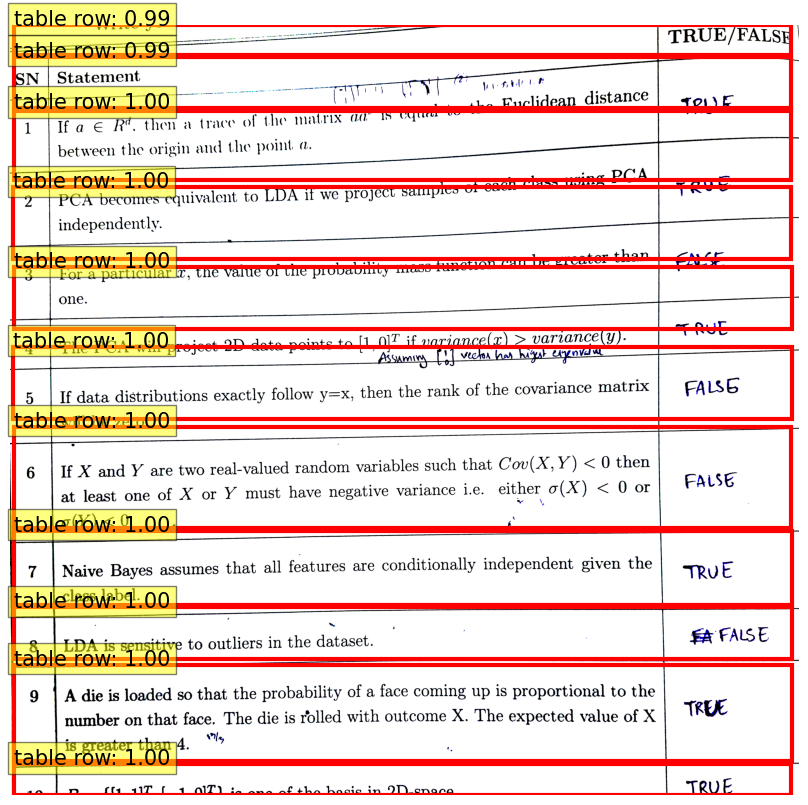

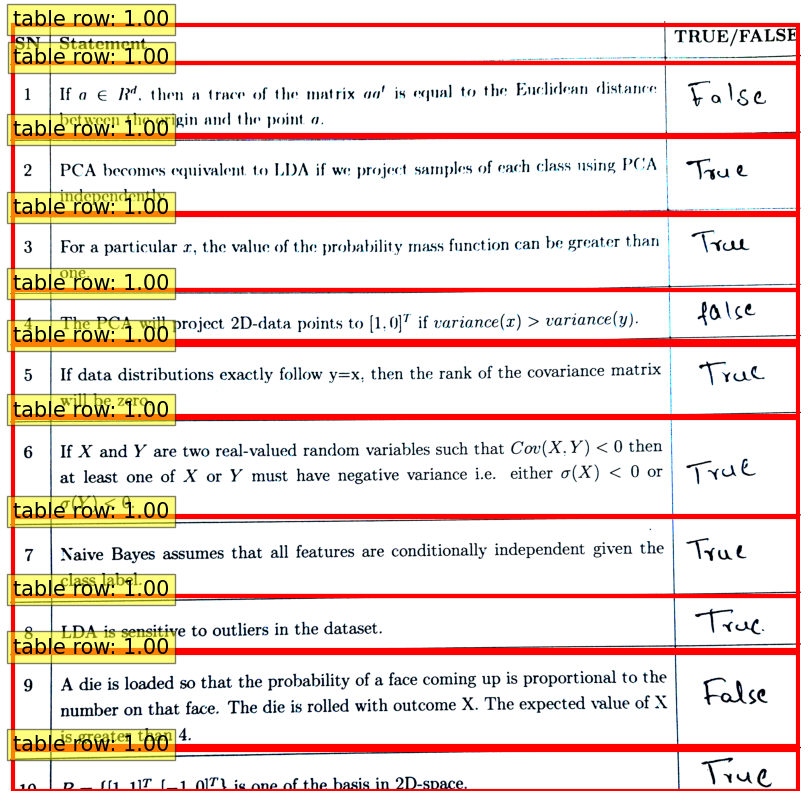

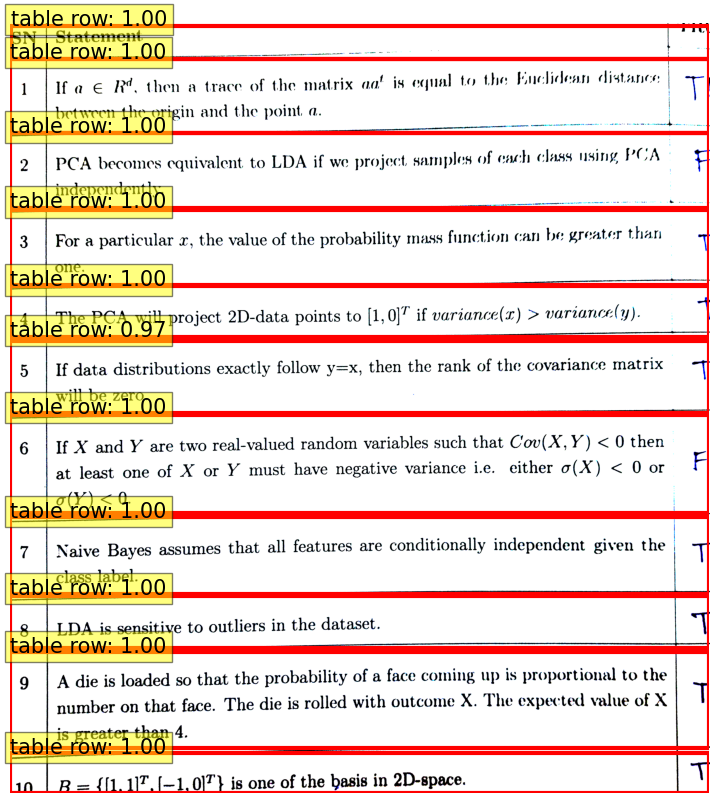

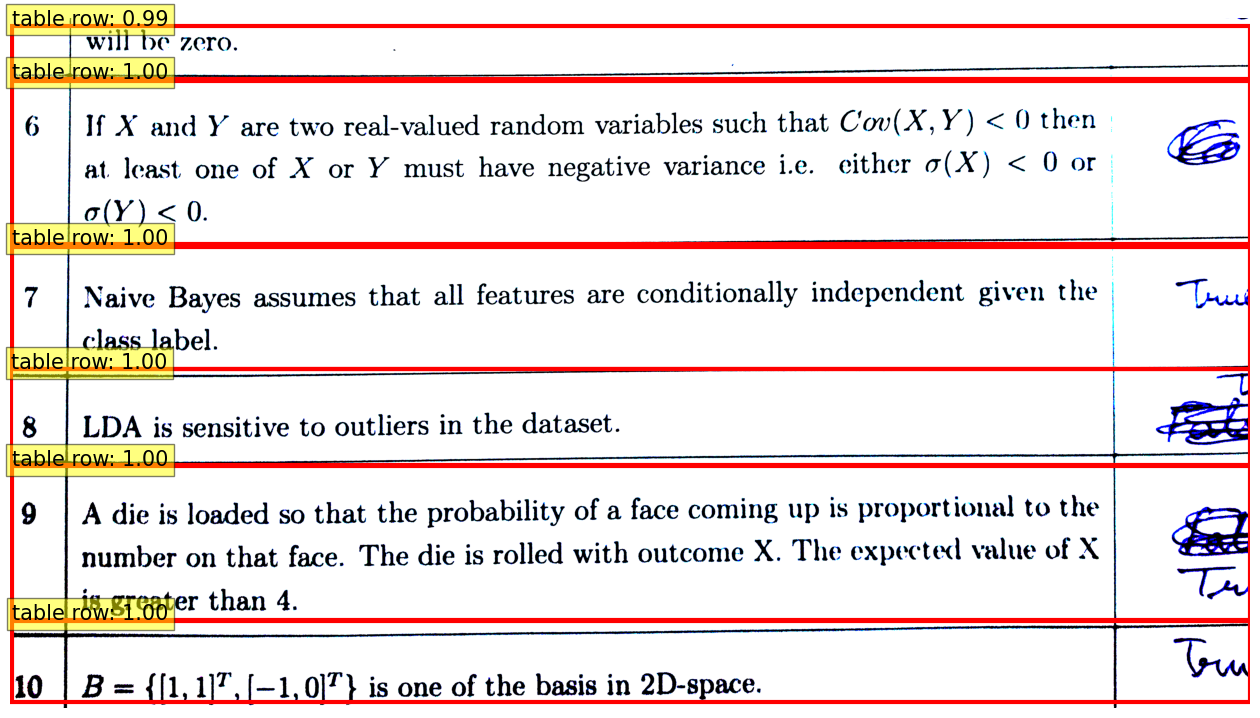

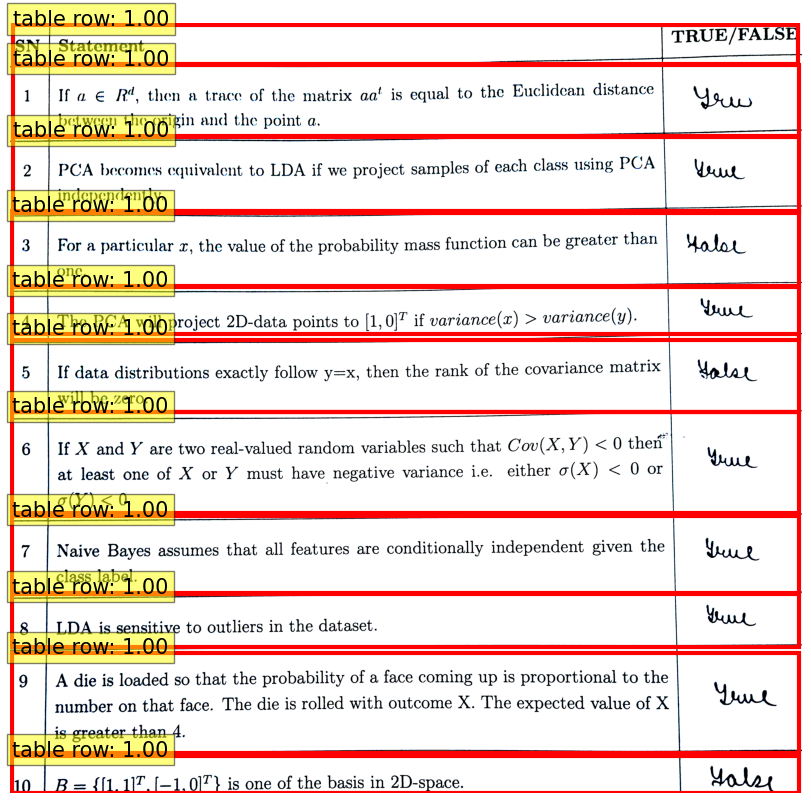

In [25]:
i=0
fdata=[]
for cropped_table in cropped_tables:
    cur=[]
    i+=1
    pixel_values = structure_transform(cropped_table).unsqueeze(0)
    pixel_values = pixel_values.to(device)
    print(pixel_values.shape)

    with torch.no_grad():
        outputs = structure_model(pixel_values)

    structure_id2label = structure_model.config.id2label
    structure_id2label[len(structure_id2label)] = "no object"

    cells = outputs_to_objects(outputs, cropped_table.size, structure_id2label)
    plot_results(cells, class_to_visualize="table row")
    cell_coordinates = get_cell_coordinates_by_row(cells)
    cols=len(cell_coordinates[0]["cells"])
    print(f"{i}) rows : {len(cell_coordinates)}  cols : {cols}")

    data = apply_ocr(cell_coordinates)

    for row, row_data in data.items():
        print(row_data)
        cur.append(row_data[-1])
    cur=np.array(cur)
    fdata.append(cur)

df=pd.DataFrame(fdata)
df

In [ ]:
# structure_id2label = structure_model.config.id2label
# structure_id2label[len(structure_id2label)] = "no object"

# cells = outputs_to_objects(outputs, cropped_table.size, structure_id2label)
# print(cells)

In [ ]:
# cropped_table_visualized = cropped_table.copy()
# draw = ImageDraw.Draw(cropped_table_visualized)

# for cell in cells:
#     draw.rectangle(cell["bbox"], outline="red")
# cropped_table_visualized.show()

In [ ]:
# plot_results(cells, class_to_visualize="table row")

In [ ]:
# print(f"rows : {len(cell_coordinates)}  cols : {len(cell_coordinates[0]["cells"])}")

In [ ]:
# reader = easyocr.Reader(['en']) # this needs to run only once to load the model into memory

# def apply_ocr(cell_coordinates):
#     # let's OCR row by row
#     data = dict()
#     max_num_columns = 0
#     for idx, row in enumerate(tqdm(cell_coordinates)):
#       row_text = []
#       for cell in row["cells"]:
#         # crop cell out of image
#         cell_image = np.array(cropped_table.crop(cell["cell"]))
#         # apply OCR
#         result = reader.readtext(np.array(cell_image))
#         if len(result) > 0:
#           # print([x[1] for x in list(result)])
#           text = " ".join([x[1] for x in result])
#           row_text.append(text)

#       if len(row_text) > max_num_columns:
#           max_num_columns = len(row_text)

#       data[idx] = row_text

#     print("Max number of columns:", max_num_columns)

#     # pad rows which don't have max_num_columns elements
#     # to make sure all rows have the same number of columns
#     for row, row_data in data.copy().items():
#         if len(row_data) != max_num_columns:
#           row_data = row_data + ["" for _ in range(max_num_columns - len(row_data))]
#         data[row] = row_data

#     return data

# data = apply_ocr(cell_coordinates)

# for row, row_data in data.items():
#     print(row_data)

In [ ]:
# with open('output.csv','w') as result_file:
#     wr = csv.writer(result_file, dialect='excel')

#     for row, row_text in data.items():
#       wr.writerow(row_text)
# df = pd.read_csv("output.csv")
# a=[]
# a.append(np.array(df['TRUE/FALSE']))
# df=pd.DataFrame(a,index=None)
# df